In [ ]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
sys.path.append('../experiments')
import dvu
import seaborn as sns
import os
import pandas as pd
from copy import deepcopy
from matplotlib import pyplot as plt
from os.path import join
import numpy as np
import imodelsx.process_results
import neuro.features.qa_questions as qa_questions
import joblib
from tqdm import tqdm
from neuro import analyze_helper, viz
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch
import spacy
fit_encoding = __import__('02_fit_encoding')
dvu.set_style()

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
device = torch.device("cuda:0")
path = f"KomeijiForce/Cuckoo-C4-Super-Rainbow"
tokenizer = AutoTokenizer.from_pretrained(path)
tagger = AutoModelForTokenClassification.from_pretrained(path).to(device)

In [74]:
def next_tokens_extraction(text):

    def find_sequences(lst):
        sequences = []
        i = 0
        while i < len(lst):
            if lst[i] == 0:
                start = i
                end = i
                i += 1
                while i < len(lst) and lst[i] == 1:
                    end = i
                    i += 1
                sequences.append((start, end+1))
            else:
                i += 1
        return sequences

    text = " ".join([token.text for token in nlp(text)])
    tokens = tokenizer.tokenize(text)
    print(tokens)

    inputs = tokenizer(text, return_tensors="pt").to(device)
    tag_predictions = tagger(**inputs).logits[0].argmax(-1).cpu().numpy()

    # only keep relevant tokens
    start_idx = tokens.index('ĊĊ')
    print(start_idx)
    input_ids = inputs.input_ids[0, start_idx:]
    tag_predictions = tag_predictions[start_idx:]
    tokens = tokens[start_idx:]

    predictions = [tokenizer.decode(input_ids[seq[0]:seq[1]]).strip(
    ) for seq in find_sequences(tag_predictions)]

    return tokens, tag_predictions, predictions

In [75]:
text = "Tom and Jack went to their trip in Paris and London."

tag_predictions_list = []
questions = [
    "What is the person mentioned here?",
    "What is the city mentioned here?",
    "Who goes with Tom together?",
    "What do Tom and Jack go to Paris for?",
    "Where does George live in?",
]
for question in questions:
    prompt = f"User:\n\n{text}\n\nQuestion: {question}\n\nAssistant:"
    tokens, tag_predictions, predictions = next_tokens_extraction(prompt)
    print(question, predictions)
    print(len(tokens), len(tag_predictions), len(predictions))
    tag_predictions_list.append(tag_predictions[-30:])

# df = pd.DataFrame(tag_predictions_list, columns=tokens[-30:], index=questions)

['ĠUser', 'Ġ:', 'Ġ', 'ĊĊ', 'ĠTom', 'Ġand', 'ĠJack', 'Ġwent', 'Ġto', 'Ġtheir', 'Ġtrip', 'Ġin', 'ĠParis', 'Ġand', 'ĠLondon', 'Ġ.', 'Ġ', 'ĊĊ', 'ĠQuestion', 'Ġ:', 'ĠWhat', 'Ġis', 'Ġthe', 'Ġperson', 'Ġmentioned', 'Ġhere', 'Ġ?', 'Ġ', 'ĊĊ', 'ĠAssistant', 'Ġ:']
3
What is the person mentioned here? ['Tom', 'Jack']
28 30 2
['ĠUser', 'Ġ:', 'Ġ', 'ĊĊ', 'ĠTom', 'Ġand', 'ĠJack', 'Ġwent', 'Ġto', 'Ġtheir', 'Ġtrip', 'Ġin', 'ĠParis', 'Ġand', 'ĠLondon', 'Ġ.', 'Ġ', 'ĊĊ', 'ĠQuestion', 'Ġ:', 'ĠWhat', 'Ġis', 'Ġthe', 'Ġcity', 'Ġmentioned', 'Ġhere', 'Ġ?', 'Ġ', 'ĊĊ', 'ĠAssistant', 'Ġ:']
3
What is the city mentioned here? ['Paris', 'London']
28 30 2
['ĠUser', 'Ġ:', 'Ġ', 'ĊĊ', 'ĠTom', 'Ġand', 'ĠJack', 'Ġwent', 'Ġto', 'Ġtheir', 'Ġtrip', 'Ġin', 'ĠParis', 'Ġand', 'ĠLondon', 'Ġ.', 'Ġ', 'ĊĊ', 'ĠQuestion', 'Ġ:', 'ĠWho', 'Ġgoes', 'Ġwith', 'ĠTom', 'Ġtogether', 'Ġ?', 'Ġ', 'ĊĊ', 'ĠAssistant', 'Ġ:']
3
Who goes with Tom together? ['Jack']
27 29 1
['ĠUser', 'Ġ:', 'Ġ', 'ĊĊ', 'ĠTom', 'Ġand', 'ĠJack', 'Ġwent', 'Ġto', 'Ġtheir', 'Ġ

In [65]:
tag_predictions[3:]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2])

In [61]:
tag_predictions

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [43]:
np.vstack(tag_predictions_list).shape

(5, 30)

In [44]:
len(tokens[-32:])

30

<Axes: >

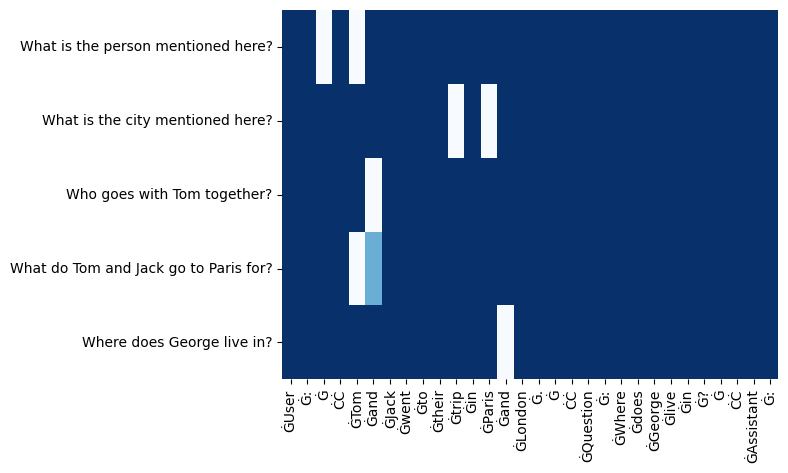

In [46]:
sns.heatmap(df, cmap="Blues", cbar=False)

In [ ]:
tag_predictions

In [ ]:
tokens

In [ ]:
len(tag_predictions)